In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns

# Web Analytics Case

The dataset in the link contains source / medium based performance report of an account.The date range is from 01.09.2019 to 31.08.2020. Analyze the channel performance based on given metrics. Also consider the change of metrics in given time period.


In [43]:
df=pd.read_csv("Case Dataset  - Dataset.csv")
df.head()

,Source / Medium,Year,Month of the year,Users,New Users,Sessions,Bounce Rate,Pageviews,Avg. Session Duration,Conversion Rate (%),Transactions,Revenue,Quantity Sold
0,A,2019,11,"126,870","104,020","194,667",71.59%,"455,159",00:01:11,0.2,394,"83,244",482
1,A,2020,5,"120,625","98,574","194,114",64.56%,"559,509",00:01:32,0.69,"1,347","203,552","2,402"
2,A,2019,10,"123,361","104,308","181,175",41.91%,"368,907",00:01:05,0.26,477,"94,282",599
3,A,2019,9,"106,551","88,428","170,329",75.92%,"368,803",00:01:01,0.18,311,"54,971",415
4,A,2020,6,"102,123","82,461","163,446",67.10%,"425,410",00:01:20,0.7,"1,138","167,113","1,987"


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
Source / Medium          250 non-null object
Year                     250 non-null int64
Month of the year        250 non-null int64
Users                    250 non-null object
New Users                250 non-null object
Sessions                 250 non-null object
Bounce Rate              250 non-null object
Pageviews                250 non-null object
Avg. Session Duration    250 non-null object
Conversion Rate (%)      250 non-null object
Transactions             250 non-null object
Revenue                  250 non-null object
Quantity Sold            250 non-null object
dtypes: int64(2), object(11)
memory usage: 25.5+ KB


## Data Cleaning

In [45]:
# The most of columns have object variable type, but they must be float type. So we must change the variable types using astype() function.
# But first of all we should remove comma from the some columns using str.replace() function.

df["Users"]=df["Users"].str.replace(",","")
df["New Users"]=df["New Users"].str.replace(",","")
df["Sessions"]=df["Sessions"].str.replace(",","")
df["Pageviews"]=df["Pageviews"].str.replace(",","")
df["Transactions"]=df["Transactions"].str.replace(",","")
df["Revenue"]=df["Revenue"].str.replace(",","")
df["Quantity Sold"]=df["Quantity Sold"].str.replace(",","")
df["Conversion Rate (%)"]=df["Conversion Rate (%)"].str.replace(".","")

In [46]:
# And now, we must change variable type from object to float

df["Users"]=df["Users"].astype("float")
df["New Users"]=df["New Users"].astype("float")
df["Sessions"]=df["Sessions"].astype("float")
df["Pageviews"]=df["Pageviews"].astype("float")
df["Transactions"]=df["Transactions"].astype("float")
df["Revenue"]=df["Revenue"].astype("float")
df["Quantity Sold"]=df["Quantity Sold"].astype("float")

In [47]:
pd.options.display.max_rows
pd.set_option("display.max_rows",None)

# There is a wrong format data in "Conversion Rate (%)"  column, we must change it.
df["Conversion Rate (%)"]=df["Conversion Rate (%)"].str.replace("<001","001")


In [48]:
df["Conversion Rate (%)"]=df["Conversion Rate (%)"].astype("float")

In [49]:
# It should be rate, so we should divide to 100

df["Conversion Rate (%)"]=(df["Conversion Rate (%)"]/100)

In [50]:
df["Bounce Rate"]=df["Bounce Rate"].str.slice(0,-1, 1)
df["Bounce Rate"]=df["Bounce Rate"].str.replace(".","")
df["Bounce Rate"]=df["Bounce Rate"].astype("float")
df["Bounce Rate"]=(df["Bounce Rate"]/100)

In [51]:
df["Avg. Session Duration"]=df["Avg. Session Duration"].str.slice(3,8,1)
df["duration_minute"]=df["Avg. Session Duration"].str.slice(1,2,1)
df["duration_second"]=df["Avg. Session Duration"].str.slice(3,5,1)

df["duration_minute"]=df["duration_minute"].astype("int64")
df["duration_second"]=df["duration_second"].astype("int64")

df["avg_session_duration(sn)"]=(df["duration_minute"]*60)+(df["duration_second"])


# and now we can drop unnecessary columns

df.drop(["duration_minute"], axis=1 ,inplace=True)
df.drop(["duration_second"], axis=1, inplace=True)
df.drop(["Avg. Session Duration"], axis=1, inplace=True)

In [52]:
df.head()

,Source / Medium,Year,Month of the year,Users,New Users,Sessions,Bounce Rate,Pageviews,Conversion Rate (%),Transactions,Revenue,Quantity Sold,avg_session_duration(sn)
0,A,2019,11,126870.0,104020.0,194667.0,71.59,455159.0,0.02,394.0,83244.0,482.0,71
1,A,2020,5,120625.0,98574.0,194114.0,64.56,559509.0,0.69,1347.0,203552.0,2402.0,92
2,A,2019,10,123361.0,104308.0,181175.0,41.91,368907.0,0.26,477.0,94282.0,599.0,65
3,A,2019,9,106551.0,88428.0,170329.0,75.92,368803.0,0.18,311.0,54971.0,415.0,61
4,A,2020,6,102123.0,82461.0,163446.0,67.10,425410.0,0.07,1138.0,167113.0,1987.0,80


### Relationship Between Metrics

In [53]:
# Let's look at correlation matrix to analyze it better.

df_corr=df[["Users","New Users","Sessions","Pageviews","Conversion Rate (%)","Transactions","Revenue","Quantity Sold"]].corr()
df_corr

# I want to predict "revenue" so, i must find out relationship between continuous variables using correlation matrix.

,Users,New Users,Sessions,Pageviews,Conversion Rate (%),Transactions,Revenue,Quantity Sold
Users,1.000000,0.986702,0.990824,0.977173,-0.148049,0.717779,0.735674,0.616684
New Users,0.986702,1.000000,0.965485,0.947228,-0.138161,0.695307,0.712963,0.599797
Sessions,0.990824,0.965485,1.000000,0.982619,-0.143097,0.746478,0.760513,0.639892
Pageviews,0.977173,0.947228,0.982619,1.000000,-0.146637,0.764345,0.775667,0.662696
Conversion Rate (%),-0.148049,-0.138161,-0.143097,-0.146637,1.000000,0.298343,0.345143,0.367149
Transactions,0.717779,0.695307,0.746478,0.764345,0.298343,1.000000,0.981740,0.980625
Revenue,0.735674,0.712963,0.760513,0.775667,0.345143,0.981740,1.000000,0.951269
Quantity Sold,0.616684,0.599797,0.639892,0.662696,0.367149,0.980625,0.951269,1.000000


Relationship between "Users" and "Sessions" is higher than other metrics. There is high correlation between "transaction", "revenue" and "quantity sold". So If we want to increase revenue, we should figure out how to increase transaction or quantity sold.

In [9]:
df.describe()

,Year,Month of the year,Users,New Users,Sessions,Pageviews,Conversion Rate (%),Transactions,Revenue,Quantity Sold
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,2019.644000,6.540000,11295.556000,8743.856000,16091.296000,44112.144000,2.971320,85.052000,14772.776000,150.104000
std,0.479776,3.507937,24516.361198,20584.145069,35614.955967,93892.520116,7.991679,177.891853,29755.532131,328.209915
min,2019.000000,1.000000,41.000000,1.000000,125.000000,237.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.000000,4.000000,302.250000,144.250000,395.250000,1382.000000,0.072500,1.250000,218.750000,2.000000
50%,2020.000000,6.000000,850.500000,482.500000,1138.000000,4440.500000,0.350000,7.500000,1373.500000,14.000000
75%,2020.000000,10.000000,7836.000000,3687.750000,10214.250000,31878.250000,0.745000,82.500000,14714.250000,127.500000
max,2020.000000,12.000000,126870.000000,104308.000000,194667.000000,559509.000000,42.080000,1347.000000,203552.000000,2402.000000


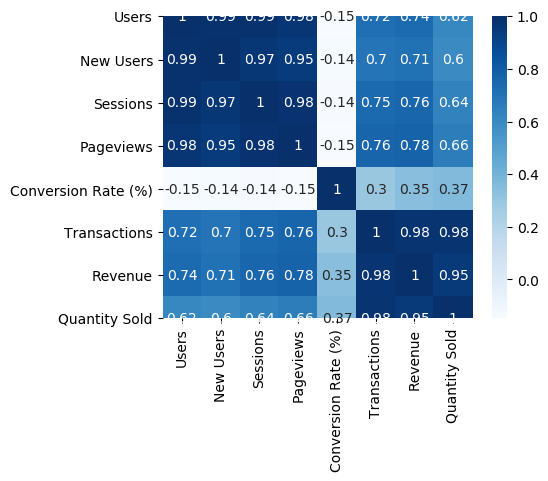

In [84]:
plt.figure(figsize=(5,4),dpi=100)
sns.heatmap(df_corr, annot=True, cmap="Blues");

## Let's Visualize Metrics

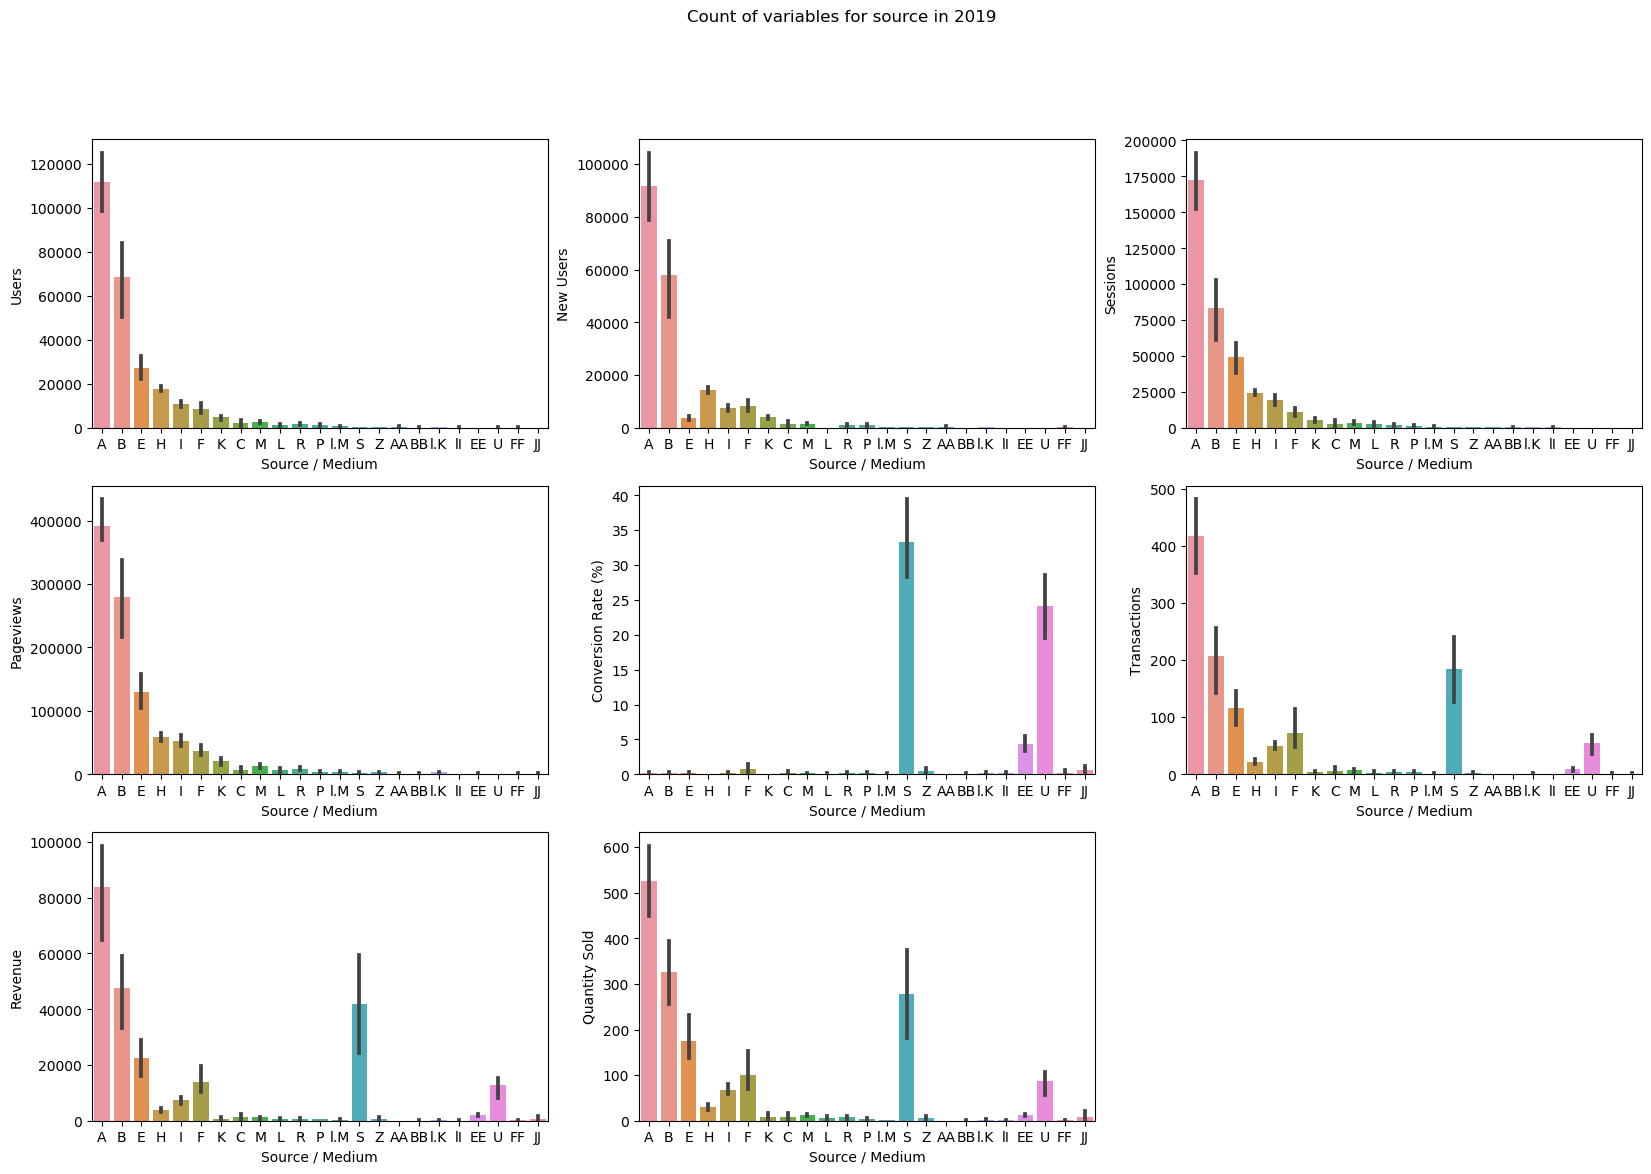

In [54]:
# According to year and source/medium, number of some continuous variables

variable=["Users","New Users","Sessions","Pageviews","Conversion Rate (%)","Transactions","Revenue","Quantity Sold"]

df_source_2019=df[df["Year"]==2019]


plt.figure(figsize=(20,13),dpi=100)
plt.suptitle("Count of variables for source in 2019")

for i in range(len(variable)):
    plt.subplot(3,3,i+1)
    plt.ylabel([variable[i]])
    sns.barplot(df_source_2019["Source / Medium"], df_source_2019[variable[i]])
    
# The most of source is usualy  A, B, C, D and S in 2019
# "Transaction", "revenue" and "quantity sold" variables are higher than in "S" source according to other sources. Maybe we can say that there is a 
# relationship between transaction, revenue and quantity sold. Anyway we know that, there is a high correlation between them because of correlation matrix and
# we prove that by visualizing

In [80]:
import plotly.express as px

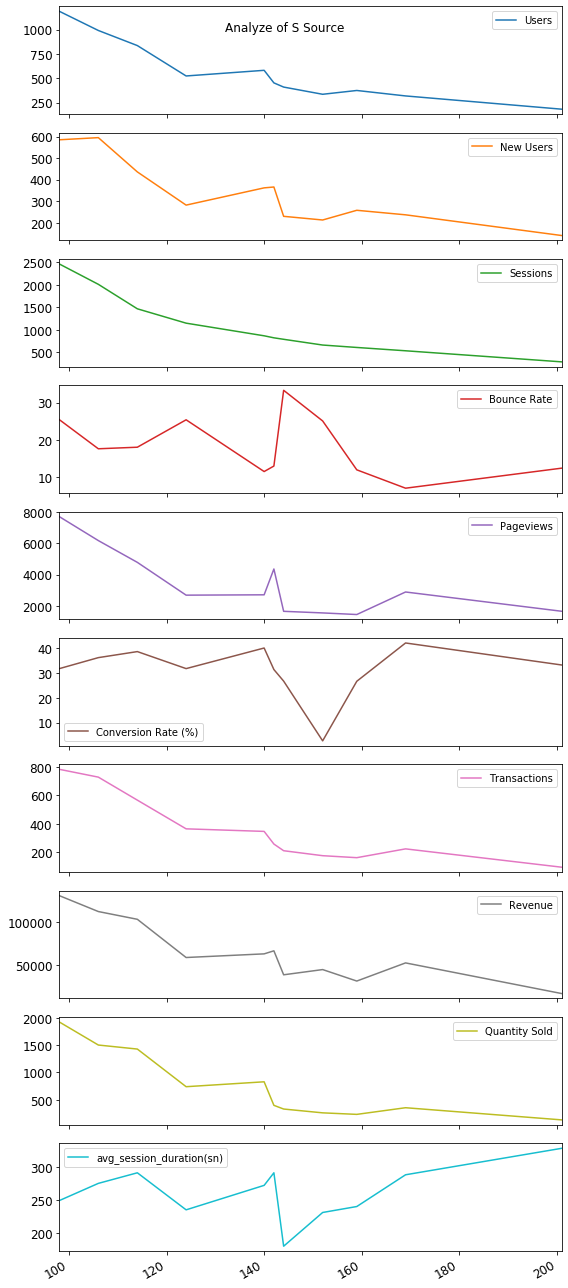

In [134]:
df_col=df.select_dtypes(exclude="O").columns.tolist()
df_S=df[df["Source / Medium"]=="S"].iloc[:,3:]


df_S.plot(subplots=True, figsize=(8,18), title="Analyze of S Source", fontsize=12)

plt.tight_layout()
plt.show();
    

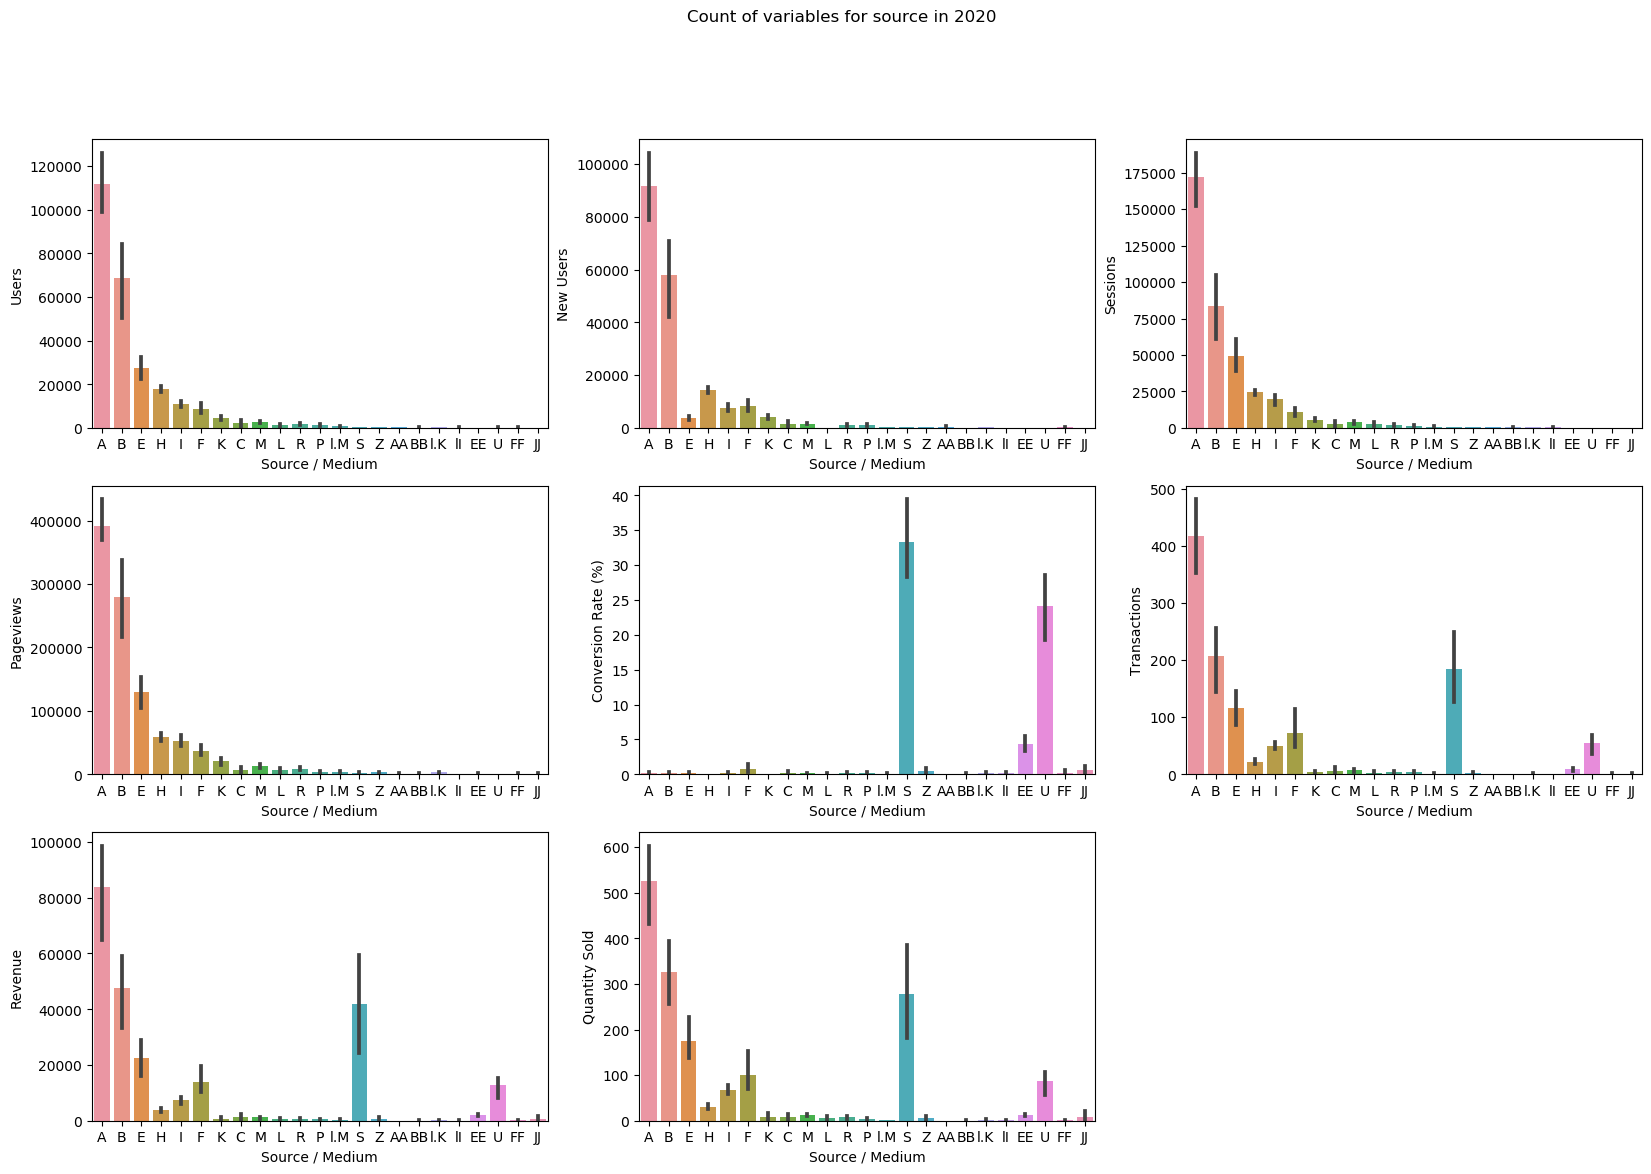

In [25]:
# Let's look 2020:

variable=["Users","New Users","Sessions","Pageviews","Conversion Rate (%)","Transactions","Revenue","Quantity Sold"]

df_source_2020=df[df["Year"]==2020]


plt.figure(figsize=(20,13),dpi=100)
plt.suptitle("Count of variables for source in 2020")

for i in range(len(variable)):
    plt.subplot(3,3,i+1)
    plt.ylabel([variable[i]])
    sns.barplot(df_source_2019["Source / Medium"], df_source_2019[variable[i]])
    
# We can say same things like up.
# A source is the most volume in other sources

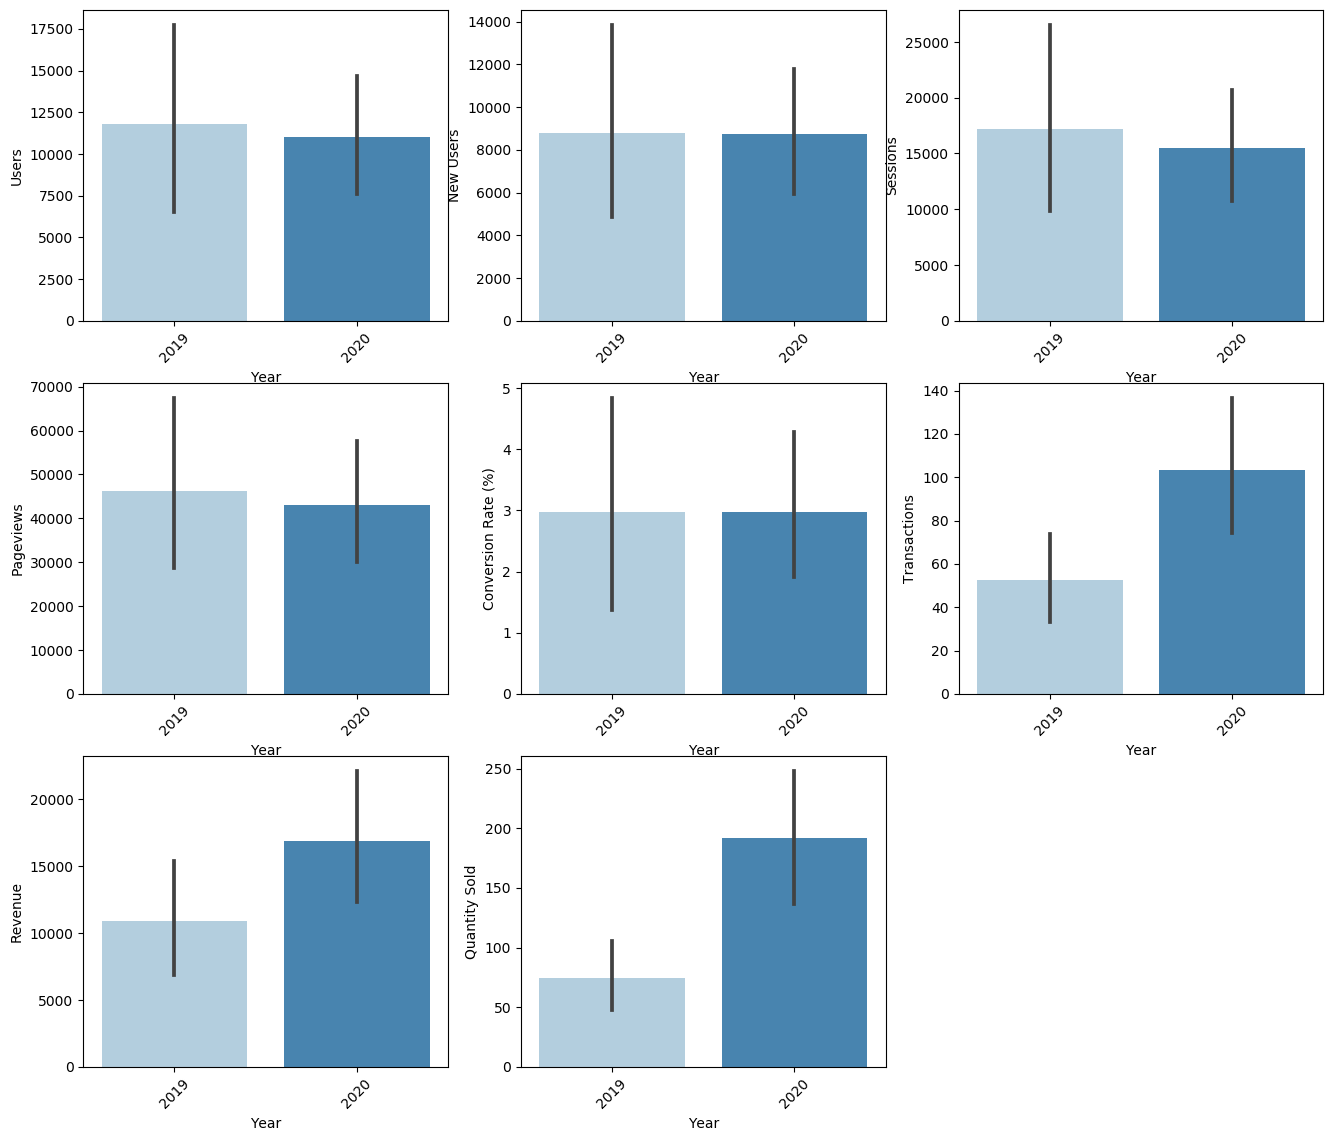

In [26]:
# According to year, number of some metrics

variable=["Users","New Users","Sessions","Pageviews","Conversion Rate (%)","Transactions","Revenue","Quantity Sold"]

plt.figure(figsize=(16,14),dpi=100)


for j in range(len(variable)):
    plt.subplot(3,3,j+1)
    plt.ylabel([variable[j]])
    plt.xticks(rotation=45)
    sns.barplot(df["Year"], df[variable[j]], palette="Blues")
    
# In 2019 year count of users is more than 2020
# In 2020 year sum of transaction is more than 2019

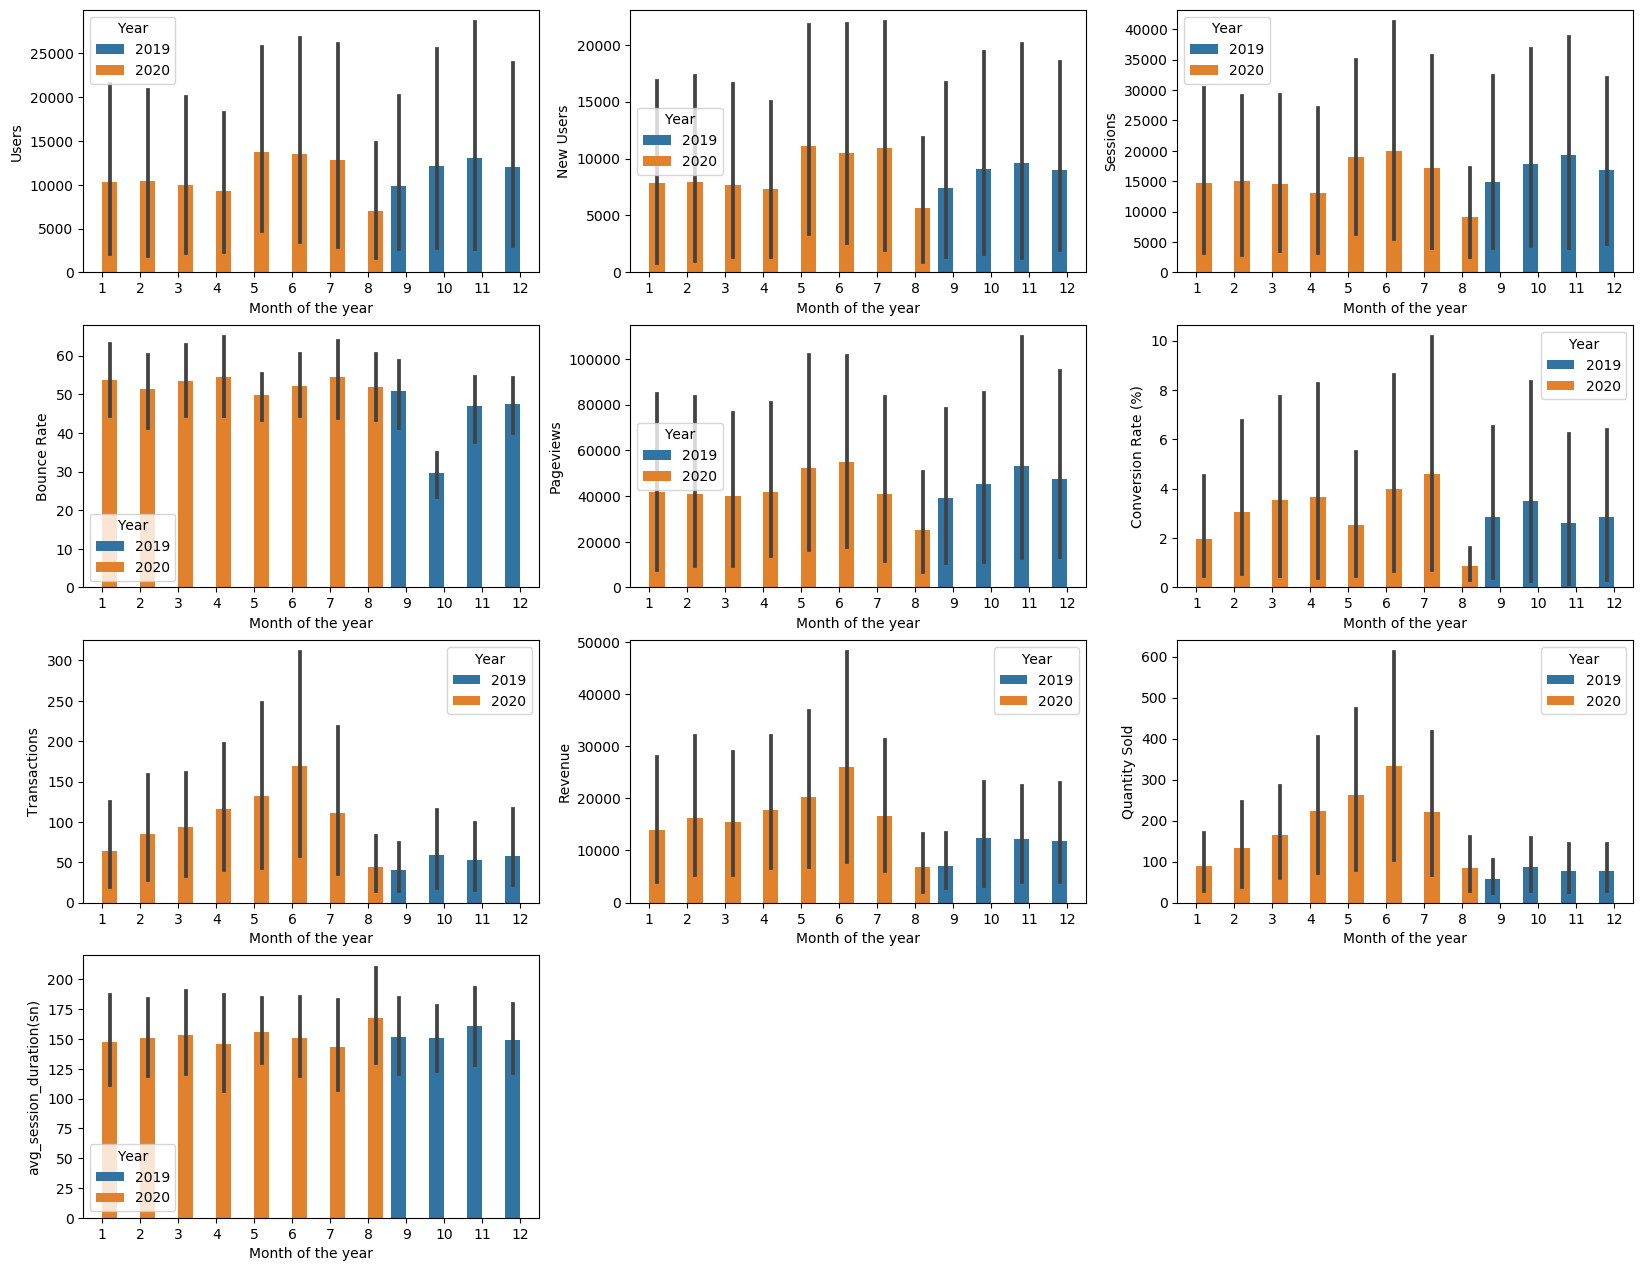

In [197]:
variable=["Users","New Users","Sessions","Bounce Rate","Pageviews","Conversion Rate (%)","Transactions","Revenue","Quantity Sold","avg_session_duration(sn)"]

plt.figure(figsize=(20,16),dpi=100)

for k in range(len(variable)):
    plt.subplot(4,3,k+1)
    plt.legend("best")
    sns.barplot(x="Month of the year", y=df[variable[k]], hue="Year", data=df);
    
# In 2019, 

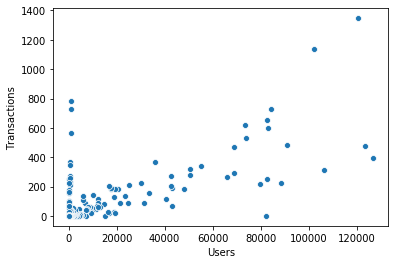

In [48]:
# Relationship between users and transactions.
sns.scatterplot(x="Users", y="Transactions", data=df)

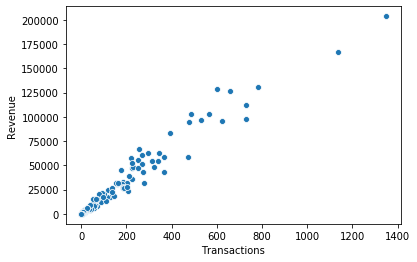

In [157]:
sns.scatterplot(df["Transactions"], df["Revenue"], data=df);

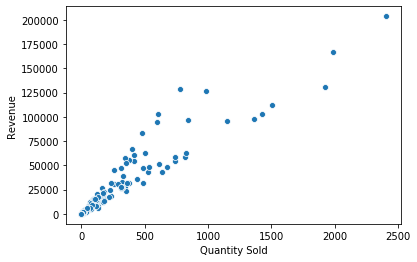

In [50]:
# There is a positive lineer relationship between quantity sold and revenue. Therefore, if we increase he revenue, we should increase quantity sold

sns.scatterplot(x="Quantity Sold", y="Revenue", data=df)

A/B testing which used to digital marketing looks like a little bit regression problems and t-test in python. Because, we measure how much changes will be if one unit increases by regression problems. Let's analyze regression problem which looks like A/B testing.

## Which metric is the most important to increase Revenue ?

In [186]:
Y=df["Revenue"]
X=df[["Sessions","Pageviews","Transactions","Quantity Sold"]]

In [187]:
lrm=linear_model.LinearRegression()
lrm.fit(X,Y)

print("Coefficients:", lrm.coef_)
print("Intercept:", lrm.intercept_)

Coefficients: [ 1.96289586e-02 -7.82737615e-03  2.13295571e+02 -2.70045746e+01]
Intercept: 714.4827426602442


According to correlation matrix, the most important variables for revenue are "transaction", "quantity sold", "pageviews"

The most impact on revenue variable is "Transaction".

In [189]:
X=sm.add_constant(X)
result=sm.OLS(Y,X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1809.
Date:                Fri, 25 Sep 2020   Prob (F-statistic):          1.55e-180
Time:                        12:32:52   Log-Likelihood:                -2502.1
No. Observations:                 250   AIC:                             5014.
Df Residuals:                     245   BIC:                             5032.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           714.4827    385.694      1.852      0.065     -45.216    1474.182
Sessions          0.0196      0.054      0.367      0.714      -0.086       0.125
Pageviews        -0.0078      0.020     -0.384      0.702      -0.048       0.032
Transactions    213.2956     16.180     13.182      0.000     181.425     245.166
Quantity Sold   -27.0046      7.570     -3.567      0.000     -41.916     -12.093
==============================================================================
Omnibus:                       53.392   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              528.944
Skew:                           0.447   Prob(JB):                    1.38e-115
Kurtosis:                      10.070   Cond. No.                     1.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### "Transaction" and "Quality Sold" metrics are the most important for Revenue